## Investigate rotated Fock eigenstates

In [3]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
%autoreload
import sppt2_v2
from pyscf import gto, scf, mp, fci
from pyscf.mp import gmp2_slow
import numpy as np
import scipy.special
from functools import reduce

mol = gto.Mole()
mol.atom = [['H', (2*i, 0., 0.)] for i in range(4)]
mol.basis = 'sto-3g'
#mol.spin = 1
mol.build()
nao = mol.nao

uhf = scf.UHF(mol).run()
rdm1 = uhf.make_rdm1()
rdm1[0][0] += 1
uhf = scf.UHF(mol).run(rdm1)
fock = uhf.get_fock()
test = sppt2_v2.SPPT2(mol, fock=fock)
ghfs, t2s = test.get_quad_ghfs_t2s()
alphas, betas, ws = test.quad

converged SCF energy = -1.57561647670187  <S^2> = 4.5519144e-14  2S+1 = 1
converged SCF energy = -1.72116940651972  <S^2> = 0.94605216  2S+1 = 2.1872834
SCF not converged.
SCF energy = -1.13157661795357 after 0 cycles  <S^2> = 0.94605223  2S+1 = 2.1872835
E(GMP2) = -1.80855753571482  E_corr = -0.0873881291945666
SCF not converged.
SCF energy = -1.13157661795357 after 0 cycles  <S^2> = 0.94605223  2S+1 = 2.1872835
E(GMP2) = -1.80855753571482  E_corr = -0.0873881291945665
SCF not converged.
SCF energy = -1.13157661795357 after 0 cycles  <S^2> = 0.94605223  2S+1 = 2.1872835
E(GMP2) = -1.80855753571482  E_corr = -0.0873881291945665
SCF not converged.
SCF energy = -1.13157661795357 after 0 cycles  <S^2> = 0.94605223  2S+1 = 2.1872835
E(GMP2) = -1.80855753571482  E_corr = -0.0873881291945664
SCF not converged.
SCF energy = -1.13157661795357 after 0 cycles  <S^2> = 0.94605223  2S+1 = 2.1872835
E(GMP2) = -1.80855753571482  E_corr = -0.0873881291945664
SCF not converged.
SCF energy = -1.1315766

In [171]:
# ovlp1 -> <(0)|(0)>
# ovlp2 -> <(0)|(1)>
# ovlp3 -> <(1)|(1)>

all_s1 = 0 # Number of ovlp1 > 0.
all_s2 = 0 # Number of ovlp2 > 0.
all_s3 = 0 # Number of ovlp3 > 0.
tot2 = 0 # Total number of ovlp2s.
tot3 = 0 # Total number of ovlp3s.
ovlp1s_all = [] # Stores all ((i2, j2),  ovlp1).
ovlp2s_all = [] # Stores all ((i2, j2),  avg ovlp2 over all doubles).
ovlp3s_all = [] # Stores all ((i2, j2),  avg ovlp3 over all doubles).
ovlp1_zeros = [] # Stores all ovlp1 = 1. (Bad variable name!)
ovlp2_zeros = [] # Stores all ovlp2 = 0.
ovlp3_zeros = [] # Stores all ovlp3 = 0.

for i1, ghf_rows1 in enumerate(ghfs):
    for j1, ghf1 in enumerate(ghf_rows1):
        for i2, ghf_rows2 in enumerate(ghfs):
            for j2, ghf2 in enumerate(ghf_rows2):
                if (i1, j1) == (i2, j2):
                    continue
                    
                alpha1 = alphas[i1]
                beta1 = betas[j1]
                alpha2 = alphas[i2]
                beta2 = betas[j2]
                ghf_mocc1 = ghf1.mo_occ
                ghf_mocc2 = ghf2.mo_occ
                ghf_mocoeff1 = ghf1.mo_coeff
                ghf_mocoeff2 = ghf2.mo_coeff
                
                ovlp1 = test.det_ovlp(ghf_mocoeff1, ghf_mocoeff2, ghf_mocc1, ghf_mocc2)[0]
                
                if abs(ovlp1 - 1) < 1e-7:
                    ovlp1_zeros.append(ovlp1)
                
                print(f'alpha1 = {alpha1}')
                print(f'beta1 = {beta1}')
                print(f'alpha2 = {alpha2}')
                print(f'beta2 = {beta2}\n')
                print('\n***** <(0)|(0)> *****\n')
                print(f'{ovlp1}')
                
                doubles1 = test.get_all_doubles(ghf_mocc1)
                doubles2 = test.get_all_doubles(ghf_mocc2)
                ovlp2s = []
                ovlp3s = []
                
                for d2 in doubles2:
                    tot2 += 1
                    ovlp2 = test.det_ovlp(ghf_mocoeff1, ghf_mocoeff2, ghf_mocc1, doubles2[d2])[0]
                    ovlp2s.append(ovlp2)
                    
                    for d1 in doubles1:
                        tot3 += 1
                        ovlp3 = test.det_ovlp(ghf_mocoeff1, ghf_mocoeff2, doubles1[d1], doubles2[d2])[0]
                        ovlp3s.append(ovlp3)
                
                print('\n***** <(0)|(1)> *****\n')
                print(len(ovlp2s))
                
                # Print and count non-zero ovlps.
                s2 = 0
                for ovlp2 in ovlp2s:
                    if ovlp2 > 1e-7:
                        s2 += 1
                        print(f'{ovlp2}')
                    
                    else:
                        ovlp2_zeros.append(ovlp2)
                
                print(f'larger than 0 = {s2}')
                
                print('\n***** <(1)|(1)> *****\n')
                print(len(ovlp3s))

                # Print and count non-zero ovlps.
                s3 = 0
                for ovlp3 in ovlp3s:
                    if ovlp3 > 1e-7:
                        s3 += 1
                        print(f'{ovlp3}')
                    
                    else:
                        ovlp3_zeros.append(ovlp3)
                        
                print(f'larger than 0 = {s3}')    
                print('\n\n')
                
                # Total count of non-zero ovlps.
                all_s2 += s2
                all_s3 += s3
                
                # Store results.
                if (i1, j1) == (0, 0):
                    ovlp1s_all.append(((i2, j2), ovlp1))
                    
                    ovlp2s_avg = sum(ovlp2s) / len(ovlp2s)
                    ovlp3s_avg = sum(ovlp3s) / len(ovlp3s)
                    
                    ovlp2s_all.append(((i2, j2), ovlp2s_avg))
                    ovlp3s_all.append(((i2, j2), ovlp3s_avg))

alpha1 = 1.5707963267948966
beta1 = 0.9553166181245093
alpha2 = 1.5707963267948966
beta2 = 2.186276035465284


***** <(0)|(0)> *****

0.6847956725121563

***** <(0)|(1)> *****

36
0.009414983819719747
0.11341573204341734
0.0003137794793664646
0.00173878698783956
0.02290264335214895
0.2758341931929964
0.0028321030207569308
0.0015225696867024554
0.005427448976150101
0.0013087774248740358
0.006605480857807918
0.006059323226965875
0.002015075624756726
0.0014137968977829323
0.008066803362609048
0.0009481969531906999
0.005312996929397502
6.819584933369653e-05
6.819584933335056e-05
0.0053129969293974014
0.0009481969531907169
0.008066803362608892
0.001413796897783095
0.0020150756247571486
0.002046223783643882
0.029071086287524386
0.0013087774248740592
0.0054274489761499765
0.0067854675243622245
0.09293098376007462
0.0006301164681853193
0.0003240401970876061
0.0017387869878395554
0.00031377947936645786
0.0022850102329019816
0.00204094148768064
larger than 0 = 36

***** <(1)|(1)> *****

1296
0.9

/Users/shufay/Documents/quantum_chemistry/spin_projected_PT/sppt2_v2.py:521: RuntimeWarning: divide by zero encountered in true_divide
  x = numpy.dot(u/s, vt)



***** <(0)|(1)> *****

36
0.028151741697556618
0.33306884348620036
0.07010028583629273
0.8293703949966473
0.00010894230195155408
0.0012889179968881964
0.0015631249436067125
0.018493641451559174
0.008533772578716054
0.008533772578715858
0.005822999580270024
0.10859282637960409
0.014499775516090734
0.2704055845199045
2.253398689689633e-05
0.00042023518858324714
0.00032332194534597815
0.006029614701439403
larger than 0 = 18

***** <(1)|(1)> *****

1296
0.780463110881146
0.011523627498625622
0.30618160767964303
0.004520806614225547
0.0508280779078653
0.0007504824098861986
0.003402631061027979
5.024023854025662e-05
0.0015631249436067198
0.10859282637960424
0.26204643434044683
0.003402631061027999
0.1028028069930067
0.0013348780154772712
0.017065914319892694
0.0002215981694078959
0.0011424592969061019
1.4834651344893029e-05
0.01152362749862561
0.00017014768395287163
0.21379671822326277
0.0031567331074135708
0.06818477643463822
0.0010067560577241604
0.2620464343404468
0.0038691457092354803
0

Let's look at the results. First we print the number of ovlp2s and ovlp3s > 0.

In [158]:
print(all_s2)
print(all_s3)

1872
65840


Number of ovlp1s = 1.

In [160]:
print(ovlp1_zeros)

[]


Which is what we intuitively expect! Since the Fock rotations essentially give rotated determinants!

Now let's take a look at the number of ovlp2s and ovlp3s = 0.

In [326]:
# Expected number of ovlps.
# 4*2 quad points, 4C2 = 6 possible choices of doubles. 
e_ovlp2s = (4*2)*(4*2-1)*36
e_ovlp3s = (4*2)*(4*2-1)*1296

print(len(ovlp2_zeros))
print(len(ovlp3_zeros))
print(len(ovlp2_zeros) / e_ovlp2s)
print(len(ovlp3_zeros) / e_ovlp3s)

144
6736
0.07142857142857142
0.09281305114638448


Let's check that this is what we expect.

In [327]:
print(e_ovlp2s - 144) # expected number of <(0)|(1)> - zeros
print(e_ovlp3s - 6736) # expected number of <(1)|(1)> - zeros

1872
65840


They match `all_s2` and `all_s3` above!

Let's see if the rotated Focks are indeed different.

In [322]:
focks = test.rotated_focks
focks.shape

(4, 2, 8, 8)

In [323]:
np.diagonal(focks[0,0] - focks[2,1])

array([-0.434+0.j,  0.424+0.j,  0.019+0.j, -0.006+0.j,  0.434+0.j,
       -0.424+0.j, -0.019+0.j,  0.006+0.j])

Let's try plotting the ovlps and see how they vary wrt the quad points.

In [311]:
ovlp2s_all

[((0, 1), 0.01744246155312716),
 ((1, 0), 0.017442461553127148),
 ((1, 1), 0.034143686354557015),
 ((2, 0), 0.03414368635455697),
 ((2, 1), 0.047370286935730005),
 ((3, 0), 0.017442461553127155),
 ((3, 1), 0.03414368635455703)]

In [312]:
ovlp1s_all_grid = np.ones((len(alphas), len(betas)))

for i in ovlp1s_all:
    ovlp1s_all_grid[i[0][0], i[0][1]] = i[1]
    
print(ovlp1s_all_grid)

[[1.    0.685]
 [0.685 0.37 ]
 [0.37  0.055]
 [0.685 0.37 ]]


In [313]:
ovlp2s_all_grid = np.ones((len(alphas), len(betas)))

for i in ovlp2s_all:
    ovlp2s_all_grid[i[0][0], i[0][1]] = i[1]
    
print(ovlp2s_all_grid)

[[1.    0.017]
 [0.017 0.034]
 [0.034 0.047]
 [0.017 0.034]]


In [314]:
ovlp3s_all_grid = np.ones((len(alphas), len(betas)))

for i in ovlp3s_all:
    ovlp3s_all_grid[i[0][0], i[0][1]] = i[1]
    
print(ovlp3s_all_grid)

[[1.    0.062]
 [0.062 0.065]
 [0.065 0.031]
 [0.062 0.065]]


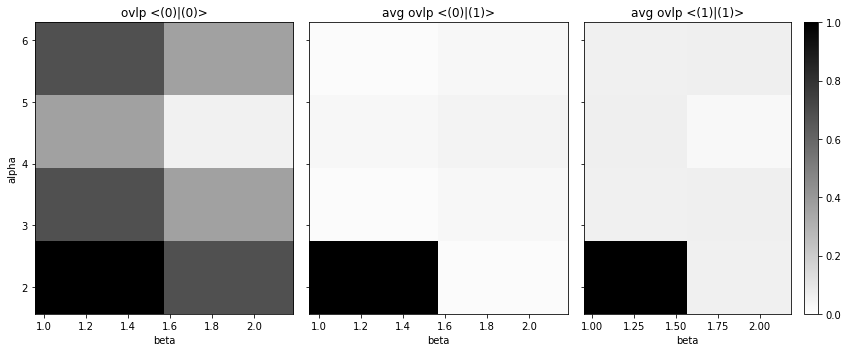

In [537]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 5]

ovlps_all_grids = [ovlp1s_all_grid, ovlp2s_all_grid, ovlp3s_all_grid]
titles = ['<(0)|(0)>', '<(0)|(1)>', '<(1)|(1)>']
fig, axs = plt.subplots(1, 3, sharey=True)
avg = ''

for i in range(3):
    if i == 0:
        axs[i].set_ylabel('alpha')
    
    else:
        avg = 'avg '
        
    im = axs[i].imshow(ovlps_all_grids[i][::-1], vmin=0, vmax=1, aspect='auto',
                       extent=(betas.min(), betas.max(), alphas.min(), alphas.max()), cmap='gist_yarg')
    axs[i].set_xlabel('beta')
    axs[i].set_title(avg + 'ovlp ' + titles[i])

fig.colorbar(im)
plt.tight_layout()
plt.show()

Okay, so we learned that:

1. The overlap between determinants formed from the eigenstates of the rotated Fock (zeroth determinants) is 0 < ovlp < 1 and are larger than the higher order overlaps.

2. The overlap between a zeroth determinant and a doubly excited determinant is 0 <= ovlp < 1. On average, this overlap smaller than the <(1)|(1)> overlaps. 

3. The overlap between two doubly excited determinants 0 <= ovlp < 1.

We can still apply the equations in Jiménez-Hoyos' paper to the cases when the overlap is > 0.

**Q: How about in the cases when the overlap is 0?**

## TODO:

- Check if whenever we get unreasonably big energies, the overlap is 0.
- If it is, then we need to figure out how to calculate the matrix element, if it's not 0.

## Calculate matrix elements

In [94]:
all_s1 = 0 # Number of ovlp1 > 0.
all_s2 = 0 # Number of ovlp2 > 0.
all_s3 = 0 # Number of ovlp3 > 0.

me1s_all = [] # Stores all ((i2, j2),  me1).
me2s_all = [] # Stores all ((i2, j2),  avg me2 over all doubles w/ non-zero ovlp).
me3s_all = [] # Stores all ((i2, j2),  avg me3 over all doubles w/ non-zero ovlp).

large = [] # stores matrix elements > 10 when ovlp != 0
large_zero = [] # stores matrix elements > 10 when ovlp == 0

for i1, ghf_rows1 in enumerate(ghfs):
    for j1, ghf1 in enumerate(ghf_rows1):
        for i2, ghf_rows2 in enumerate(ghfs):
            for j2, ghf2 in enumerate(ghf_rows2):
                if (i1, j1) == (i2, j2):
                    continue
                    
                alpha1 = alphas[i1]
                beta1 = betas[j1]
                alpha2 = alphas[i2]
                beta2 = betas[j2]
                ghf_mocc1 = ghf1.mo_occ
                ghf_mocc2 = ghf2.mo_occ
                ghf_mocoeff1 = ghf1.mo_coeff
                ghf_mocoeff2 = ghf2.mo_coeff
                
                ovlp1 = test.det_ovlp(ghf_mocoeff1, ghf_mocoeff2, ghf_mocc1, ghf_mocc2)[0]
                me1 = test.get_matrix_element(ghf_mocoeff1, ghf_mocoeff2, ghf_mocc1, ghf_mocc2, divide=True)
                
                print(f'alpha1 = {alpha1}')
                print(f'beta1 = {beta1}')
                print(f'alpha2 = {alpha2}')
                print(f'beta2 = {beta2}\n')
                
                """
                print('\n***** ghf info *****\n')
                
                print(f'ghf_mocoeff1 diag: {np.diagonal(ghf_mocoeff1)}\n')
                print(f'ghf_mocoeff2 diag: {np.diagonal(ghf_mocoeff2)}')
                
                for i in range(5):
                    print(f'ghf_mocoeff1 diag: \n{ghf_mocoeff1[:, i]}\n')
                    print(f'ghf_mocoeff2 diag: \n{ghf_mocoeff2[:, i]}\n')
                """
                
                print('\n<(0)|(0)> \t\t\t\t\t <(0)|H|(0)>\n')
                print(f'{ovlp1:.4e} \t\t\t\t {me1:.4e}')
                
                doubles1 = test.get_all_doubles(ghf_mocc1)
                doubles2 = test.get_all_doubles(ghf_mocc2)
                ovlp2s = []
                ovlp3s = []
                me2s = []
                me3s = []
                
                for d2 in doubles2:
                    ovlp2 = test.det_ovlp(ghf_mocoeff1, ghf_mocoeff2, ghf_mocc1, doubles2[d2])[0]
                    me2 = test.get_matrix_element(ghf_mocoeff1, ghf_mocoeff2, ghf_mocc1, doubles2[d2], divide=True)
                    ovlp2s.append(ovlp2)
                    me2s.append(me2)
                    
                    for d1 in doubles1:
                        ovlp3 = test.det_ovlp(ghf_mocoeff1, ghf_mocoeff2, doubles1[d1], doubles2[d2])[0]
                        me3 = test.get_matrix_element(
                            ghf_mocoeff1, ghf_mocoeff2, doubles1[d1], doubles2[d2], doubles=d1, divide=True)
                        ovlp3s.append(ovlp3)
                        me3s.append(me3)
                    
                print('\n<(0)|(1)> \t\t\t\t\t <(0)|H|(1)>\n')
                print(len(ovlp2s))
                s2 = 0
                me2_ovlp2_nonzero = 0
                
                for i, ovlp2 in enumerate(ovlp2s):
                    if ovlp2 > 1e-7:
                        s2 += 1
                        me2_ovlp2_nonzero += me2s[i]
                        print(f'{ovlp2:.4e} \t\t\t\t\t {me2s[i]:.4e}')
                        
                        if (abs(np.real(me2s[i])) > 10) or (abs(np.imag(me2s[i])) > 10):
                            large.append(('01', ovlp2, me2s[i]))
                            
                    else:
                        if (abs(np.real(me2s[i])) > 10) or (abs(np.imag(me2s[i])) > 10):
                            large_zero.append(('01', ovlp2, me2s[i]))
                        
                
                print(f'larger than 0 = {s2}')
                
                print('\n<(1)|(1)> \t\t\t\t\t <(1)|H|(1)>\n')
                print(len(ovlp3s))
                s3 = 0
                me3_ovlp3_nonzero = 0
                
                for j, ovlp3 in enumerate(ovlp3s):
                    if ovlp3 > 1e-7:
                        s3 += 1
                        me3_ovlp3_nonzero += me3s[j]
                        print(f'{ovlp3:.4e} \t\t\t\t {me3s[j]:.4e}')
                        
                        if (abs(np.real(me3s[j])) > 10) or (abs(np.imag(me3s[j])) > 10):
                            large.append(('11', ovlp3, me3s[j]))
                            
                    else:
                        if (abs(np.real(me3s[j])) > 10) or (abs(np.imag(me3s[j])) > 10):
                            large_zero.append(('11', ovlp3, me3s[j]))
                        
                        
                print(f'larger than 0 = {s3}')    
                print('\n\n')
                
                all_s2 += s2
                all_s3 += s3
                
                # Store results.
                if (i1, j1) == (0, 0):
                    me1s_all.append(((i2, j2), me1))
                    
                    # We only calculate the average using matrix elements between states
                    # w/ non-zero overlap.
                    me2s_avg = me2_ovlp2_nonzero / s2
                    me3s_avg = me3_ovlp3_nonzero / s3
                    
                    me2s_all.append(((i2, j2), me2s_avg))
                    me3s_all.append(((i2, j2), me3s_avg))

alpha1 = 1.5707963267948966
beta1 = 0.9553166181245093
alpha2 = 1.5707963267948966
beta2 = 2.186276035465284


<(0)|(0)> 					 <(0)|H|(0)>

6.8480e-01 				 -1.1102e-16-1.8769e-15j

<(0)|(1)> 					 <(0)|H|(1)>

36
9.4150e-03 					 3.6118e-01-2.2136e-15j
1.1342e-01 					 4.6593e-01-2.3819e-15j
3.1378e-04 					 5.6014e+00+8.4634e-15j
1.7388e-03 					 2.6174e+00+2.9554e-14j
2.2903e-02 					 2.0332e-01-2.3053e-15j
2.7583e-01 					 3.0648e-01-2.4820e-15j
2.8321e-03 					 4.5176e+00-2.6446e-15j
1.5226e-03 					 -1.4340e+00-2.4802e-16j
5.4274e-03 					 5.7660e+00-4.0037e-15j
1.3088e-03 					 2.6711e+00-1.9445e-15j
6.6055e-03 					 4.3187e+00-2.7980e-15j
6.0593e-03 					 6.6543e-01-2.1694e-15j
2.0151e-03 					 5.9978e+00-8.8369e-15j
1.4138e-03 					 6.2287e+00+2.5184e-14j
8.0668e-03 					 7.6293e+00+1.6355e-14j
9.4820e-04 					 4.5423e+00-6.7758e-15j
5.3130e-03 					 5.9358e+00-6.9899e-15j
6.8196e-05 					 6.5591e+00-4.7721e-13j
6.8196e-05 					 1.5603e+00-7.9497e-14j
5.3130e-03 					 2.1837e+0

/Users/shufay/Documents/quantum_chemistry/spin_projected_PT/sppt2_v2.py:683: RuntimeWarning: divide by zero encountered in true_divide
  return 0



<(0)|(1)> 					 <(0)|H|(1)>

36
2.8152e-02 					 -1.1620e-01-6.7863e-16j
3.3307e-01 					 -1.2891e-01-9.0178e-16j
7.0100e-02 					 -9.3636e-02-7.8497e-16j
8.2937e-01 					 -1.0634e-01-1.0205e-15j
1.0894e-04 					 -8.2971e+00-2.7855e-14j
1.2889e-03 					 -8.3098e+00-1.0845e-14j
1.5631e-03 					 -2.3314e-01+5.9956e-15j
1.8494e-02 					 -2.4585e-01-1.6704e-15j
8.5338e-03 					 -1.5141e+00-7.7664e-15j
8.5338e-03 					 -1.1924e+00+8.3496e-16j
5.8230e-03 					 6.8574e-01-3.9820e-15j
1.0859e-01 					 -4.2479e-02-1.3029e-15j
1.4500e-02 					 7.0831e-01-3.3488e-15j
2.7041e-01 					 -1.9911e-02-1.1440e-15j
2.2534e-05 					 -7.4952e+00-1.1352e-13j
4.2024e-04 					 -8.2234e+00-1.2170e-14j
3.2332e-04 					 5.6880e-01+1.5474e-14j
6.0296e-03 					 -1.5942e-01-1.8265e-15j
larger than 0 = 18

<(1)|(1)> 					 <(1)|H|(1)>

1296
7.8046e-01 				 2.5062e-03+7.7613e-17j
1.1524e-02 				 3.2755e+00-1.6862e-15j
3.0618e-01 				 -1.9247e-01+1.4089e-17j
4.5208e-03 				 1.1436e+01-2.2489e-14j
5.0828e-02 				 4.281

Let's process the matrix element results like we did above.

In [95]:
me1s_all_grid = np.zeros((len(alphas), len(betas)), dtype=np.complex)

for i in me1s_all:
    me1s_all_grid[i[0][0], i[0][1]] = i[1]
    
print(me1s_all_grid)
print(np.absolute(me1s_all_grid))

[[ 0.000e+00+0.000e+00j -1.110e-16-1.877e-15j]
 [ 1.426e-01+9.475e-01j  0.000e+00+1.753e+00j]
 [ 2.608e-01-1.641e-15j -1.443e-15-4.795e-16j]
 [ 1.426e-01-9.475e-01j -2.220e-16-1.753e+00j]]
[[0.000e+00 1.880e-15]
 [9.581e-01 1.753e+00]
 [2.608e-01 1.521e-15]
 [9.581e-01 1.753e+00]]


In [96]:
me2s_all_grid = np.zeros((len(alphas), len(betas)), dtype=np.complex)

for i in me2s_all:
    me2s_all_grid[i[0][0], i[0][1]] = i[1]
    
print(me2s_all_grid)
print(np.absolute(me2s_all_grid))

[[0.   +0.000e+00j 2.502-1.742e-14j]
 [1.588-1.048e+00j 0.804+8.789e-01j]
 [3.314+3.911e-14j 1.901+3.771e-14j]
 [1.588+1.048e+00j 0.804-8.789e-01j]]
[[0.    2.502]
 [1.903 1.191]
 [3.314 1.901]
 [1.903 1.191]]


In [97]:
me3s_all_grid = np.zeros((len(alphas), len(betas)), dtype=np.complex)

for i in me3s_all:
    me3s_all_grid[i[0][0], i[0][1]] = i[1]
    
print(me3s_all_grid)
print(np.absolute(me3s_all_grid))

[[ 0.   +0.000e+00j  2.093+4.908e-14j]
 [ 1.264+2.070e+00j  1.404+6.396e+00j]
 [ 1.204-2.326e-13j -1.3  +6.888e-14j]
 [ 1.264-2.070e+00j  1.404-6.396e+00j]]
[[0.    2.093]
 [2.425 6.548]
 [1.204 1.3  ]
 [2.425 6.548]]


Because the bra and ket states are not the same and can have complex MO coeffs, the matrix element is complex. But the energy computed in the end needs to be real, so hopefully when we sum everything up it will give a real value.

To visualise the relative sizes of the matrix elements, I'll plot both the real part and the absolute value.

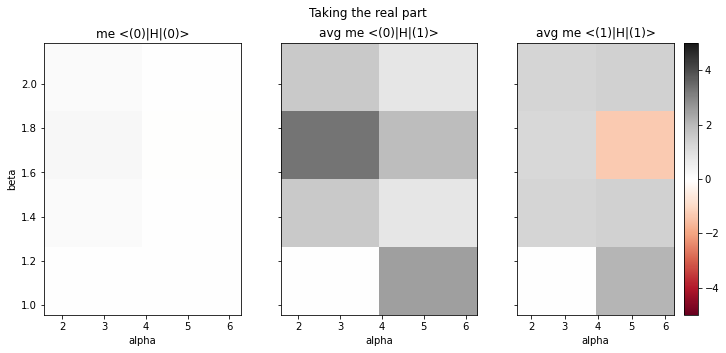

In [98]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 5]

mes_all_grids = [me1s_all_grid, me2s_all_grid, me3s_all_grid]
titles = ['<(0)|H|(0)>', '<(0)|H|(1)>', '<(1)|H|(1)>']
fig, axs = plt.subplots(1, 3, sharey=True)
avg = ''

for i in range(3):
    if i == 0:
        axs[i].set_ylabel('beta')
    
    else:
        avg = 'avg '
        
    im = axs[i].imshow(np.real(mes_all_grids[i][::-1]), vmin=-5, vmax=5, aspect='auto',
                       extent=(alphas.min(), alphas.max(), betas.min(), betas.max()), cmap='RdGy')
    axs[i].set_xlabel('alpha')
    axs[i].set_title(avg + 'me ' + titles[i])

fig.colorbar(im)
fig.suptitle('Taking the real part')
plt.show()

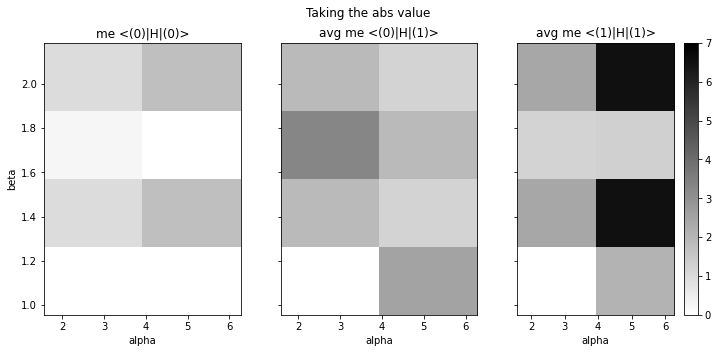

In [99]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 5]

mes_all_grids = [me1s_all_grid, me2s_all_grid, me3s_all_grid]
titles = ['<(0)|H|(0)>', '<(0)|H|(1)>', '<(1)|H|(1)>']
fig, axs = plt.subplots(1, 3, sharey=True)
avg = ''

for i in range(3):
    if i == 0:
        axs[i].set_ylabel('beta')
    
    else:
        avg = 'avg '
        
    im = axs[i].imshow(np.absolute(mes_all_grids[i][::-1]), vmin=0, vmax=7, aspect='auto',
                       extent=(alphas.min(), alphas.max(), betas.min(), betas.max()), cmap='gist_yarg')
    axs[i].set_xlabel('alpha')
    axs[i].set_title(avg + 'me ' + titles[i])

fig.colorbar(im)
fig.suptitle('Taking the abs value')
plt.show()

What does this tell us? It's telling us that 

1. the matrix elements <(0)|H|(0)> are smaller than <(0)|H|(1)> on average. 

2. the real part of <(0)|H|(1)> is larger than <(1)|H|(1)> on average, but the absolute value of <(0)|H|(1)> is smaller than <(1)|H|(1)> on average.

Now let's take a look at the matrix elements between states with 0 overlap.

In [100]:
np.set_printoptions(precision=3)
print(len(large_zero))

s = 0
l = []

for i, item in enumerate(large_zero):
    s += item[2]
    
    if (abs(np.real(item[2])) < 1e7) and (abs(np.imag(item[2])) < 1e7):
        l.append(item)

print(s / len(large_zero))
print(len(l))
l

6131
(-928532206817546-5292355064319844j)
19


[('01', 3.2189072608184575e-18, (-12.613402006670679+0.12828055471165647j)),
 ('11', 2.0228507182091867e-18, (29.938955803398944-3.3553378230364457j)),
 ('11', 1.174806686472527e-46, (-10.683433515148884+1.6758761555232278j)),
 ('11', 2.890378960906492e-17, (-7.961012500710239+24.20040512739423j)),
 ('11', 3.9915939844066884e-18, (11.1740936443219-14.978569906526284j)),
 ('11', 2.508113236840927e-18, (-15.76786912615653+0.08238240879473581j)),
 ('01', 7.523966552815978e-18, (-20.040200789182755-2.7668274136524227j)),
 ('11', 1.771024236399895e-17, (-16.08831523965793+0.5733623288208278j)),
 ('11', 8.127478173894553e-19, (-10.376535985221185-5.751140261093467j)),
 ('11', 1.0432242295818234e-16, (-1.2329302989422448+60.07940585504351j)),
 ('01', 3.2189072608184564e-18, (-12.604785834005703+0.8820607789596301j)),
 ('11', 2.0228507182091883e-18, (29.98438525986905+2.8953081872113438j)),
 ('11', 2.890378960906505e-17, (-9.682101442051101-23.552708545733143j)),
 ('11', 5.434937330250838e-19,

So there are cases where the overlap is 0, but the matrix elements don't blow up. Why does this happen? It happens more frequently with the <(1)|H|(1)> matrix elements than the <(0)|H|(1)> matrix elements. **Does this suggest some numerical instability with the <(1)|H|(1)> computation?**

Let's try computing the energy from the cross terms while omitting the <(1)|H|(1)> matrix elements and the <(0)|H|(1)> matrix elements where <(0)|(1)> = 0.

In [149]:
n_alpha = len(alphas)
n_beta = len(betas)
s = m = k = 0

# < psi(0)_g | H | psi(0)_g' >
matrix_elems_00 = np.zeros((n_alpha, n_beta, n_alpha, n_beta), dtype=np.complex)

# < psi(0)_g | H | psi(1)_g' >
matrix_elems_01 = np.zeros((n_alpha, n_beta, n_alpha, n_beta), dtype=np.complex)

# < psi(1)_g | H | psi(1)_g' >
matrix_elems_11 = np.zeros((n_alpha, n_beta, n_alpha, n_beta), dtype=np.complex)

for row1, ghf_row1 in enumerate(ghfs):
    for row2, ghf_row2 in enumerate(ghfs):
        for col1, ghf1 in enumerate(ghf_row1):
            for col2, ghf2 in enumerate(ghf_row2):
                if (row1, col1) == (row2, col2): # We only want diff quad points.
                    continue

                mo_coeff1 = ghf1.mo_coeff
                mo_coeff2 = ghf2.mo_coeff
                mo_occ1 = ghf1.mo_occ
                mo_occ2 = ghf2.mo_occ

                # Array of doubly excited mo_occs.
                mo_occ1_ds = test.get_all_doubles(mo_occ1)
                mo_occ2_ds = test.get_all_doubles(mo_occ2)

                # < psi(0)_g | H | psi(0)_g' >
                matrix_elems_00[row1, col1, row2, col2] = test.get_matrix_element(
                    mo_coeff1, mo_coeff2, mo_occ1, mo_occ2)
                
                # Skip <(0)|H|(1)> matrix elements where <(0)|(0)> = 0.
                ovlp = test.det_ovlp(mo_coeff1, mo_coeff2, mo_occ1, mo_occ2)[0]
                if ovlp < 1e-7:
                    continue
                
                # < psi(0)_g | H | psi(1)_g' >
                matrix_elem_01 = 0
                
                # < psi(1)_g | H | psi(1)_g' >
                matrix_elem_11 = 0

                for mo_occ2_d in mo_occ2_ds:
                    # Skip <(0)|H|(1)> matrix elements where <(0)|(0)> = 0.
                    ovlp2 = test.det_ovlp(mo_coeff1, mo_coeff2, mo_occ1, mo_occ2_ds[mo_occ2_d])[0]
                    if ovlp2 < 1e-7:
                        continue
                        
                    i, j, a, b = [int(s) for s in mo_occ2_d.split(',')]
                    matrix_elem_sd = test.get_matrix_element(
                        mo_coeff1, mo_coeff2, mo_occ1, mo_occ2_ds[mo_occ2_d])

                    matrix_elem_01 += t2s[row2][col2][i, j, a % test.nelec, b % test.nelec] * matrix_elem_sd 
                    
                    for mo_occ1_d in mo_occ1_ds:
                        # Skip <(0)|H|(1)> matrix elements where <(0)|(0)> = 0.
                        ovlp2 = test.det_ovlp(mo_coeff1, mo_coeff2, mo_occ1_ds[mo_occ1_d], mo_occ2_ds[mo_occ2_d])[0]
                        if ovlp2 < 1e-7:
                            continue
                        
                        h, l, c, d = [int(s) for s in mo_occ1_d.split(',')]
                        matrix_elem_dd = test.get_matrix_element(
                            mo_coeff1, mo_coeff2, mo_occ1_ds[mo_occ1_d], mo_occ2_ds[mo_occ2_d], doubles=mo_occ1_d)

                        matrix_elem_11 += np.conj(t2s[row1][col1][h, l, c % test.nelec, d % test.nelec]) * \
                            t2s[row2][col2][i, j, a % test.nelec, b % test.nelec] * matrix_elem_dd

                matrix_elems_01[row1, col1, row2, col2] = matrix_elem_01
                matrix_elems_11[row1, col1, row2, col2] = matrix_elem_11

coeffs = np.sqrt(test.quad_coeffs(s, m, k))
x_energy1 = 0
x_energy2 = 0

for alpha_g in range(n_alpha):
    for beta_g in range(n_beta):
        for alpha_gp in range(n_alpha):
            for beta_gp in range(n_beta):
                if (alpha_g, beta_g) == (alpha_gp, beta_gp):
                    continue

                """
                DONT THINK THIS IS CORRECT.
                """
                x_energy1 += np.conj(coeffs[alpha_g, beta_g]) * coeffs[alpha_gp, beta_gp] * \
                    (matrix_elems_00[alpha_g, beta_g, alpha_gp, beta_gp] + \
                     matrix_elems_01[alpha_g, beta_g, alpha_gp, beta_gp] + \
                     np.conj(matrix_elems_01[alpha_gp, beta_gp, alpha_g, beta_g]))
  
                x_energy2 += np.conj(coeffs[alpha_g, beta_g]) * coeffs[alpha_gp, beta_gp] * \
                    (matrix_elems_00[alpha_g, beta_g, alpha_gp, beta_gp] + \
                     matrix_elems_01[alpha_g, beta_g, alpha_gp, beta_gp] + \
                     np.conj(matrix_elems_01[alpha_gp, beta_gp, alpha_g, beta_g]) + \
                     matrix_elems_11[alpha_g, beta_g, alpha_gp, beta_gp])
    
x_energy1 /= test.norm(s, m, k)
x_energy2 /= test.norm(s, m, k)

/Users/shufay/Documents/quantum_chemistry/spin_projected_PT/sppt2_v2.py:683: RuntimeWarning: divide by zero encountered in true_divide
  x = numpy.dot(u/s, vt)
/Users/shufay/Documents/quantum_chemistry/spin_projected_PT/sppt2_v2.py:683: RuntimeWarning: invalid value encountered in true_divide
  x = numpy.dot(u/s, vt)


In [150]:
x_energy1

(-1.4784528284454892-2.5919666329859906e-16j)

In [151]:
x_energy2

(-1.6366860277747608-1.4986584624036995e-16j)

In [152]:
ghfs[0][0].e_tot

-1.131576617953567

The energies look much more reasonable compared to the first time and the negative sign is encouraging. However, they still overcorrect. Is this an issue with normalization? If it is, then we should see a bond curve closer to the FCI result but just scaled by some factor. 

Let's look at the relative sizes of each term.

In [105]:
energy_00 = 0

for alpha_g in range(n_alpha):
    for beta_g in range(n_beta):
        for alpha_gp in range(n_alpha):
            for beta_gp in range(n_beta):
                if (alpha_g, beta_g) == (alpha_gp, beta_gp):
                    continue
                    
                energy_00 += np.conj(coeffs[alpha_g, beta_g]) * coeffs[alpha_gp, beta_gp] * \
                    matrix_elems_00[alpha_g, beta_g, alpha_gp, beta_gp]

In [106]:
energy_00

(-6.909695739983026-1.2622825729547203e-15j)

In [107]:
energy_01 = 0

for alpha_g in range(n_alpha):
    for beta_g in range(n_beta):
        for alpha_gp in range(n_alpha):
            for beta_gp in range(n_beta):
                if (alpha_g, beta_g) == (alpha_gp, beta_gp):
                    continue
                    
                energy_01 += np.conj(coeffs[alpha_g, beta_g]) * coeffs[alpha_gp, beta_gp] * \
                    (matrix_elems_01[alpha_g, beta_g, alpha_gp, beta_gp] + \
                     np.conj(matrix_elems_01[alpha_gp, beta_gp, alpha_g, beta_g]))

In [108]:
energy_01

(-0.13220908176469473+2.6616087003520015e-19j)

In [109]:
energy_11 = 0

for alpha_g in range(n_alpha):
    for beta_g in range(n_beta):
        for alpha_gp in range(n_alpha):
            for beta_gp in range(n_beta):
                if (alpha_g, beta_g) == (alpha_gp, beta_gp):
                    continue
                    
                energy_11 += np.conj(coeffs[alpha_g, beta_g]) * coeffs[alpha_gp, beta_gp] * \
                    (matrix_elems_11[alpha_g, beta_g, alpha_gp, beta_gp])

In [110]:
energy_11

(-0.7536683672815921+5.298795992236215e-16j)

From this preliminary look, the <(0)|H|(0)> term has the largest magnitude, followed by <(1)|H|(1)> and then <(0)|H|(1)>. However, in computing these results, we simply omitted the matrix elements between states that are orthogonal. **It's not clear whether the matrix elements would be 0 or not...**

## Bond Curves
### H2
Let's try computing the total energy over a few bond lengths with just H2.

In [183]:
%autoreload
import sppt2_v2

s = m = k = 0
bond_lengths, e_sppt2_3, e_gmp2_3, e_fci = sppt2_v2.bond_curve(2, s, m, k, order=3)


Bond Length: 0.5
Building molecule...
Using basis set sto-3g

*** Check energy ***

alphas = [3.142 6.283]
betas = [1.571]
ws = [2.]
Ng = 1

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
E_mp2 = -2.1098404914619864
alpha_t = 3.141592653589793
beta_g = 1.5707963267948966
ws_g = 2.0
d^s_mk = 1.0

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
E_mp2 = -2.1098404914619864
alpha_t = 6.283185307179586
beta_g = 1.5707963267948966
ws_g = 2.0
d^s_mk = 1.0

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679

s = 0
m

In [184]:
np.array(e_sppt2_3)-np.array(e_fci)

array([-8.789e-01+2.585e-16j, -7.856e-01+2.467e-16j,
       -7.135e-01+2.356e-16j, -6.549e-01+2.250e-16j,
       -6.052e-01+2.151e-16j, -5.617e-01+2.058e-16j,
       -5.226e-01+1.971e-16j, -4.865e-01+1.888e-16j,
       -4.211e-01+1.586e-16j, -3.242e-01+1.396e-16j,
       -2.478e-01+1.124e-16j, -1.850e-01+8.794e-17j,
       -1.357e-01+6.734e-17j, -9.831e-02+5.073e-17j,
       -7.066e-02+3.775e-17j, -5.051e-02+2.783e-17j,
       -3.598e-02+2.038e-17j, -2.557e-02+1.484e-17j,
       -1.814e-02+1.076e-17j, -1.881e-02+7.667e-18j,
       -1.336e-02+5.537e-18j, -9.453e-03+3.980e-18j,
       -6.658e-03+2.848e-18j, -4.668e-03+2.029e-18j,
       -2.207e-03+1.442e-18j, -1.535e-03+1.016e-18j,
       -1.062e-03+7.120e-19j, -7.317e-04+4.964e-19j,
       -7.345e-04+3.439e-19j, -3.416e-04+2.372e-19j,
       -3.378e-04+1.626e-19j, -2.273e-04+1.108e-19j,
       -1.047e-04+7.510e-20j, -6.981e-05+5.065e-20j,
       -6.712e-05+3.395e-20j, -4.425e-05+2.266e-20j,
       -2.903e-05+1.505e-20j, -1.895e-05+9.831

In [185]:
e_sppt2_3

[(-1.934049418516129+2.5845661135005274e-16j),
 (-1.8988087706712855+2.4672915161388184e-16j),
 (-1.8483319979528243+2.3556714234932463e-16j),
 (-1.7908887400058686+2.2502411983705166e-16j),
 (-1.73105815227444+2.1511480470565663e-16j),
 (-1.6712635043592274+2.0581077875504954e-16j),
 (-1.6127142301166701+1.9705793927014162e-16j),
 (-1.5560342206528532+1.8880048194928256e-16j),
 (-1.4702442294263753+1.5855652855872437e-16j),
 (-1.3539251117789446+1.3959525888615676e-16j),
 (-1.2598729263112187+1.1237197963134558e-16j),
 (-1.1814811553256293+8.794214254455293e-17j),
 (-1.118872678226015+6.734264168563224e-17j),
 (-1.070406091934147+5.073011536838613e-17j),
 (-1.033709819849777+3.7749489905730447e-17j),
 (-1.0063590088008882+2.7833393538932795e-17j),
 (-0.9861975271107292+2.0379528086908822e-17j),
 (-0.9714503358371762+1.484098793750056e-17j),
 (-0.9607219561569572+1.0759872364717557e-17j),
 (-0.9589079428490078+7.667032626580077e-18j),
 (-0.9516099602450836+5.536792415058508e-18j),
 (-0

Let's check the sizes of the imaginary parts.

In [186]:
np.imag(e_sppt2_3)

array([ 2.585e-16,  2.467e-16,  2.356e-16,  2.250e-16,  2.151e-16,
        2.058e-16,  1.971e-16,  1.888e-16,  1.586e-16,  1.396e-16,
        1.124e-16,  8.794e-17,  6.734e-17,  5.073e-17,  3.775e-17,
        2.783e-17,  2.038e-17,  1.484e-17,  1.076e-17,  7.667e-18,
        5.537e-18,  3.980e-18,  2.848e-18,  2.029e-18,  1.442e-18,
        1.016e-18,  7.120e-19,  4.964e-19,  3.439e-19,  2.372e-19,
        1.626e-19,  1.108e-19,  7.510e-20,  5.065e-20,  3.395e-20,
        2.266e-20,  1.505e-20,  9.831e-21,  6.470e-21,  4.029e-21,
        2.226e-21,  8.536e-22,  2.468e-22,  4.120e-20,  3.531e-22,
       -2.628e-22,  5.079e-22,  6.041e-22,  7.546e-23, -5.948e-24])

So they're identical to 0!

/Users/shufay/envs/pyscf2/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


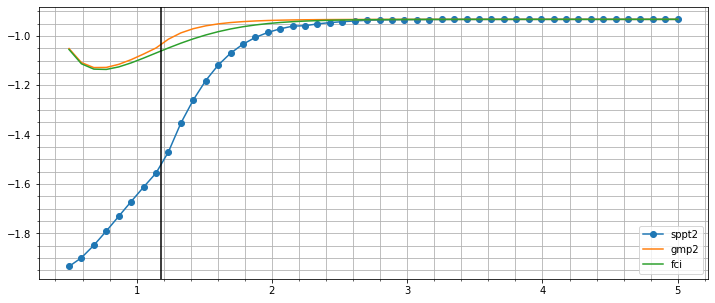

In [249]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
plt.rcParams['figure.figsize'] = [12, 5]
plt.plot(bond_lengths, e_sppt2_3, '-o', label='sppt2')
plt.plot(bond_lengths, e_gmp2_3, label='gmp2')
plt.plot(bond_lengths, e_fci, label='fci')
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(b=True, which='both')
plt.axvline(x=1.18, ymin=0, ymax=1, color='black')
plt.legend()
plt.show()

What if we dropped the <(1)|H|(1)> terms?

In [188]:
%autoreload
import sppt2_v2

s = m = k = 0
bond_lengths, e_sppt2_2, e_gmp2_2, e_fci_2 = sppt2_v2.bond_curve(2, s, m, k, order=2)


Bond Length: 0.5
Building molecule...
Using basis set sto-3g

*** Check energy ***

alphas = [3.142 6.283]
betas = [1.571]
ws = [2.]
Ng = 1

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
E_mp2 = -2.1098404914619864
alpha_t = 3.141592653589793
beta_g = 1.5707963267948966
ws_g = 2.0
d^s_mk = 1.0

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
E_mp2 = -2.1098404914619864
alpha_t = 6.283185307179586
beta_g = 1.5707963267948966
ws_g = 2.0
d^s_mk = 1.0

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679

s = 0
m

/Users/shufay/envs/pyscf2/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


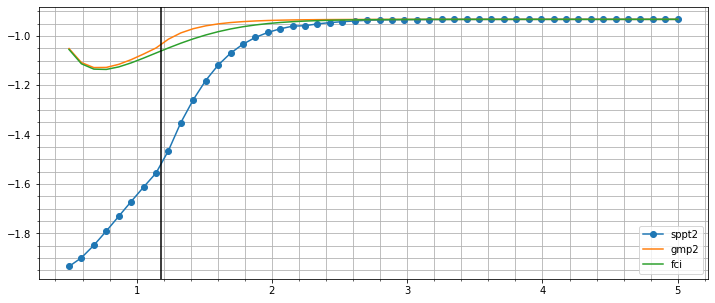

In [250]:
plt.plot(bond_lengths, e_sppt2_2, '-o', label='sppt2')
plt.plot(bond_lengths, e_gmp2_2, label='gmp2')
plt.plot(bond_lengths, e_fci_2, label='fci')
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(b=True, which='both')
plt.axvline(x=1.18, ymin=0, ymax=1, color='black')
plt.legend()
plt.show()

Let's try plotting the difference between `e_sppt2_3` and `e_sppt2_2`.

/Users/shufay/envs/pyscf2/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


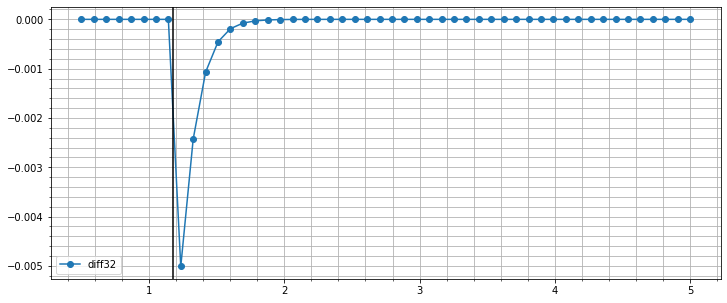

In [251]:
diff32 = np.array(e_sppt2_3)-np.array(e_sppt2_2)
plt.plot(bond_lengths, diff32, '-o', label='diff32')
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(b=True, which='both')
plt.axvline(x=1.18, ymin=0, ymax=1, color='black')
plt.legend()
plt.show()

OK it's the pretty much the same because for H2 the bra and ket states in <(1)|H|(1)> are the same (I think).

Let's check the sizes of the imaginary parts.

In [191]:
np.imag(e_sppt2_2)

array([ 2.585e-16,  2.467e-16,  2.356e-16,  2.250e-16,  2.151e-16,
        2.058e-16,  1.971e-16,  1.888e-16,  1.576e-16,  1.391e-16,
        1.122e-16,  8.786e-17,  6.731e-17,  5.072e-17,  3.774e-17,
        2.783e-17,  2.038e-17,  1.484e-17,  1.076e-17,  7.667e-18,
        5.537e-18,  3.980e-18,  2.848e-18,  2.029e-18,  1.442e-18,
        1.016e-18,  7.120e-19,  4.964e-19,  3.439e-19,  2.372e-19,
        1.626e-19,  1.108e-19,  7.510e-20,  5.065e-20,  3.395e-20,
        2.266e-20,  1.505e-20,  9.831e-21,  6.470e-21,  4.029e-21,
        2.226e-21,  8.536e-22,  2.468e-22,  4.120e-20,  3.531e-22,
       -2.628e-22,  5.079e-22,  6.041e-22,  7.546e-23, -5.948e-24])

So they're identical to 0!

Let's just try with the <(0)|H|(0)> energies.

In [192]:
%autoreload
import sppt2_v2

s = m = k = 0
bond_lengths, e_sppt2_1, e_gmp2_1, e_fci_1 = sppt2_v2.bond_curve(2, s, m, k, order=1)


Bond Length: 0.5
Building molecule...
Using basis set sto-3g

*** Check energy ***

alphas = [3.142 6.283]
betas = [1.571]
ws = [2.]
Ng = 1

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
E_mp2 = -2.1098404914619864
alpha_t = 3.141592653589793
beta_g = 1.5707963267948966
ws_g = 2.0
d^s_mk = 1.0

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
E_mp2 = -2.1098404914619864
alpha_t = 6.283185307179586
beta_g = 1.5707963267948966
ws_g = 2.0
d^s_mk = 1.0

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679

s = 0
m

/Users/shufay/envs/pyscf2/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


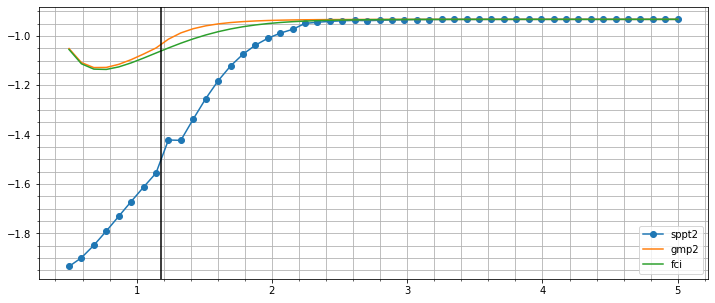

In [252]:
plt.plot(bond_lengths, e_sppt2_1, '-o', label='sppt2')
plt.plot(bond_lengths, e_gmp2_1, label='gmp2')
plt.plot(bond_lengths, e_fci_1, label='fci')
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(b=True, which='both')
plt.axvline(x=1.18, ymin=0, ymax=1, color='black')
plt.legend()
plt.show()

The kink is related to the UHF/RHF instability.
My guess is that the overcorrection is related to the normalization.

Let's try plotting the difference between `e_sppt2_2` and `e_sppt2_1`.

/Users/shufay/envs/pyscf2/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


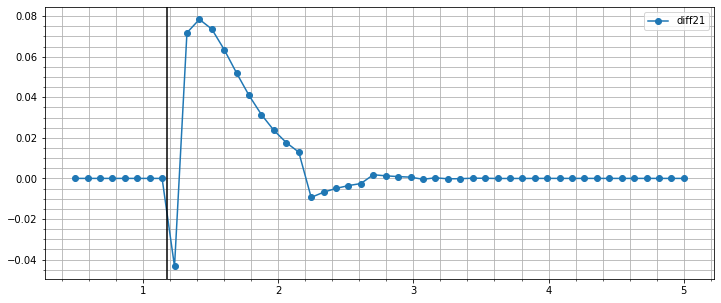

In [253]:
diff21 = np.array(e_sppt2_2)-np.array(e_sppt2_1)
plt.plot(bond_lengths, diff21, '-o', label='diff21')
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(b=True, which='both')
plt.axvline(x=1.18, ymin=0, ymax=1, color='black')
plt.legend()
plt.show()

From the difference plots, we learned that for H2 most of the energy cross-terms contribution comes from the <(0)|H|(0)> and <(0)|H|(1)> terms. <(1)|H|(1)> has a very small contribution because H2 only has 1 doubly occupied determinant, which contributes through the MP2 energy.

Let's check the sizes of the imaginary parts.

In [195]:
np.imag(e_sppt2_1)

array([ 2.585e-16,  2.467e-16,  2.356e-16,  2.250e-16,  2.151e-16,
        2.058e-16,  1.971e-16,  1.888e-16,  1.576e-16,  1.391e-16,
        1.122e-16,  8.786e-17,  6.731e-17,  5.072e-17,  3.774e-17,
        2.783e-17,  2.038e-17,  1.484e-17,  1.076e-17,  7.667e-18,
        5.537e-18,  3.980e-18,  2.848e-18,  2.029e-18,  1.442e-18,
        1.016e-18,  7.120e-19,  4.964e-19,  3.439e-19,  2.372e-19,
        1.626e-19,  1.108e-19,  7.510e-20,  5.065e-20,  3.395e-20,
        2.266e-20,  1.505e-20,  9.831e-21,  6.470e-21,  4.029e-21,
        2.226e-21,  8.536e-22,  2.468e-22,  4.120e-20,  3.531e-22,
       -2.628e-22,  5.079e-22,  6.041e-22,  7.546e-23, -5.948e-24])

So they're identical to 0!

In [198]:
%autoreload
import sppt2_v2

s = m = k = 0
bond_lengths, e_sppt2_0, e_gmp2_0, e_fci_0 = sppt2_v2.bond_curve(2, s, m, k, order=0)


Bond Length: 0.5
Building molecule...
Using basis set sto-3g

*** Check energy ***

alphas = [3.142 6.283]
betas = [1.571]
ws = [2.]
Ng = 1

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
E_mp2 = -2.1098404914619864
alpha_t = 3.141592653589793
beta_g = 1.5707963267948966
ws_g = 2.0
d^s_mk = 1.0

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
E_mp2 = -2.1098404914619864
alpha_t = 6.283185307179586
beta_g = 1.5707963267948966
ws_g = 2.0
d^s_mk = 1.0

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679

s = 0
m

/Users/shufay/envs/pyscf2/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


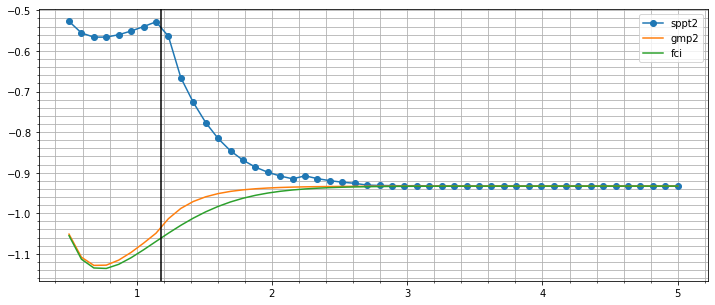

In [243]:
plt.plot(bond_lengths, e_sppt2_0, '-o', label='sppt2')
plt.plot(bond_lengths, e_gmp2_0, label='gmp2')
plt.plot(bond_lengths, e_fci_0, label='fci')
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(b=True, which='both')
plt.axvline(x=1.18, ymin=0, ymax=1, color='black')
plt.legend()
plt.show()

In [197]:
np.array(e_sppt2_0)-np.array(e_sppt2_1)

array([8.826e-01-2.585e-16j, 7.905e-01-2.467e-16j, 7.198e-01-2.356e-16j,
       6.630e-01-2.250e-16j, 6.156e-01-2.151e-16j, 5.748e-01-2.058e-16j,
       5.390e-01-1.971e-16j, 5.068e-01-1.888e-16j, 4.084e-01-1.576e-16j,
       4.352e-01-1.391e-16j, 3.661e-01-1.122e-16j, 2.952e-01-8.786e-17j,
       2.306e-01-6.731e-17j, 1.761e-01-5.072e-17j, 1.322e-01-3.774e-17j,
       9.808e-02-2.783e-17j, 7.207e-02-2.038e-17j, 5.258e-02-1.484e-17j,
       3.814e-02-1.076e-17j, 1.467e-02-7.667e-18j, 1.039e-02-5.537e-18j,
       7.331e-03-3.980e-18j, 5.153e-03-2.848e-18j, 3.607e-03-2.029e-18j,
       5.063e-03-1.442e-18j, 3.559e-03-1.016e-18j, 2.489e-03-7.120e-19j,
       1.732e-03-4.964e-19j, 5.639e-04-3.439e-19j, 8.247e-04-2.372e-19j,
       2.587e-04-1.626e-19j, 1.738e-04-1.108e-19j, 2.602e-04-7.510e-20j,
       1.753e-04-5.065e-20j, 5.108e-05-3.395e-20j, 3.361e-05-2.266e-20j,
       2.201e-05-1.505e-20j, 1.434e-05-9.831e-21j, 2.258e-05-6.470e-21j,
       1.476e-05-4.029e-21j, 3.844e-06-2.226e-21j, 

Check 0th order energy calculation by seeing if we get the GMP2 energies if we remove all the normalization factors.

In [214]:
%autoreload
import sppt2_v2

s = m = k = 0
bond_lengths, e_sppt2_, e_gmp2_, e_fci_ = sppt2_v2.bond_curve(2, s, m, k, order=0, divide_norm=False, just_mp2=True)


Bond Length: 0.5
Building molecule...
Using basis set sto-3g

*** Check energy ***

alphas = [3.142 6.283]
betas = [1.571]
ws = [2.]
Ng = 1

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
E_mp2 = -2.1098404914619864
alpha_t = 3.141592653589793
beta_g = 1.5707963267948966
ws_g = 2.0
d^s_mk = 1.0

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
E_mp2 = -2.1098404914619864
alpha_t = 6.283185307179586
beta_g = 1.5707963267948966
ws_g = 2.0
d^s_mk = 1.0

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679

s = 0
m

/Users/shufay/envs/pyscf2/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


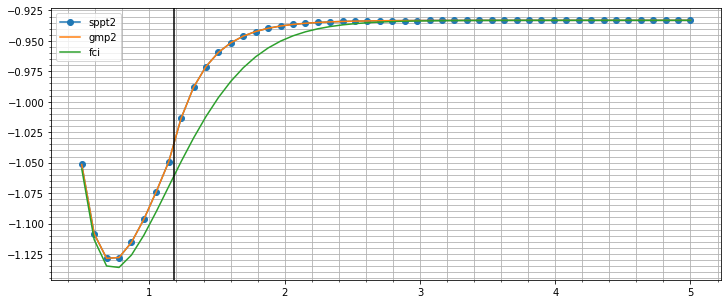

In [244]:
plt.plot(bond_lengths, e_sppt2_, '-o', label='sppt2')
plt.plot(bond_lengths, e_gmp2_, label='gmp2')
plt.plot(bond_lengths, e_fci_, label='fci')
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(b=True, which='both')
plt.axvline(x=1.18, ymin=0, ymax=1, color='black')
plt.legend()
plt.show()

Let's take a look at the 0th order energy coeffcients $\sum_g |w_g|^2 \frac{\langle\tilde{\psi}_g | \tilde{\psi}_g\rangle}{\langle\Psi | \Psi \rangle}$. 

In [269]:
def order0_coeffs(test, s, m, k):
        """
        Compute the total energy <Psi|H|Psi> / <Psi|Psi>.
        
        Args
            s (int): The quantum number for total spin.
            m (int): The quantum number for the z-component of spin to project to.
            k (int): The quantum number for the z-component of spin to project from.
            order (int): Specifies the order of the SPPT2 correction.
            divide_norm (bool): Specifies whether to return <Psi|H|Psi> or <Psi|H|Psi> / <Psi|Psi>.
            
        Returns
            <Psi|H|Psi> or <Psi|H|Psi> / <Psi|Psi>.
        """
        print('\n*** Check energy ***\n')
        if test.rotated_focks is None:
            test.get_quad_rotated_focks()

        alphas, betas, ws = test.quad
        Ng = len(betas)
        E = 0
        
        print(f'alphas = {alphas}')
        print(f'betas = {betas}')
        print(f'ws = {ws}')
        print(f'Ng = {Ng}\n')

        coeffs = test.quad_coeffs(s, m, k)
        
        for t, alpha_t in enumerate(alphas):
            for g, beta_g in enumerate(betas):
                rotated_fock = test.rotated_focks[t, g]
                mp2 = test.do_mp2(rotated_fock)
                t2 = mp2.t2
                mo_coeff = mp2.mo_coeff
                mo_occ = mp2.mo_occ
                mp2_norm = 1 + test.norm_11(mo_coeff, mo_coeff, mo_occ, mo_occ, t2, t2)
                
                E += coeffs[t, g] * mp2_norm
    
        E /= test.norm(s, m, k)
        return E

In [270]:
start = 0.5
stop = 5
points = 50
n = 2
basis = 'sto3g'
s = m = k = 0
bond_lengths = np.linspace(start, stop, points)
dms = None
order0_coeffs_ls = []

for bond_length in bond_lengths:
    print('\nBond Length: {}'.format(bond_length))
    mol = sppt2_v2.build_chain(n, bond_length, basis)
    nao = mol.nao

    if dms is None:
        uhf = scf.UHF(mol).run(dms, verbose=0)
        dms = uhf.make_rdm1()

    dms[0][0, 0]+=1.0    
    uhf = scf.UHF(mol).run(dms, verbose=0)
    dms = uhf.make_rdm1()
    fock = uhf.get_fock()
    test = sppt2_v2.SPPT2(mol, fock=fock)

    # Compute 0th order energy coefficients.
    order0_coeff = order0_coeffs(test, s, m, k)

    print('\n=====================================')
    print(f'0th order coeff = {order0_coeff}\n')

    order0_coeffs_ls.append(order0_coeff)


Bond Length: 0.5
Building molecule...
Using basis set sto3g

*** Check energy ***

alphas = [3.142 6.283]
betas = [1.571]
ws = [2.]
Ng = 1

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679

0th order coeff = (0.5000000000019552+0j)


Bond Length: 0.5918367346938775
Building molecule...
Using basis set sto3g

*** Check energy ***

alphas = [3.142 6.283]
betas = [1.571]
ws = [2.]
Ng = 1

SCF not converged.
SCF ener

/Users/shufay/envs/pyscf2/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


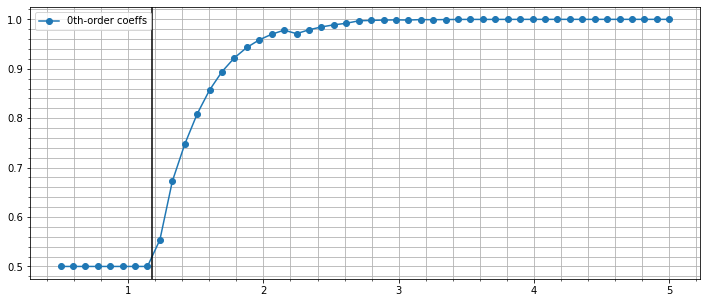

In [271]:
plt.plot(bond_lengths, order0_coeffs_ls, '-o', label='0th-order coeffs')
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(b=True, which='both')
plt.axvline(x=1.18, ymin=0, ymax=1, color='black')
plt.legend()
plt.show()

Let's try plotting 0th-order energy without the overall normalization.

In [274]:
%autoreload
import sppt2_v2

s = m = k = 0
bond_lengths, e_sppt2_0_nonorm, e_gmp2_0, e_fci_0 = sppt2_v2.bond_curve(2, s, m, k, order=0, divide_norm=False)


Bond Length: 0.5
Building molecule...
Using basis set sto-3g

*** Check energy ***

alphas = [3.142 6.283]
betas = [1.571]
ws = [2.]
Ng = 1

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
E_mp2 = -2.1098404914619864
alpha_t = 3.141592653589793
beta_g = 1.5707963267948966
ws_g = 2.0
d^s_mk = 1.0

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
E_mp2 = -2.1098404914619864
alpha_t = 6.283185307179586
beta_g = 1.5707963267948966
ws_g = 2.0
d^s_mk = 1.0

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679

s = 0
m

/Users/shufay/envs/pyscf2/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


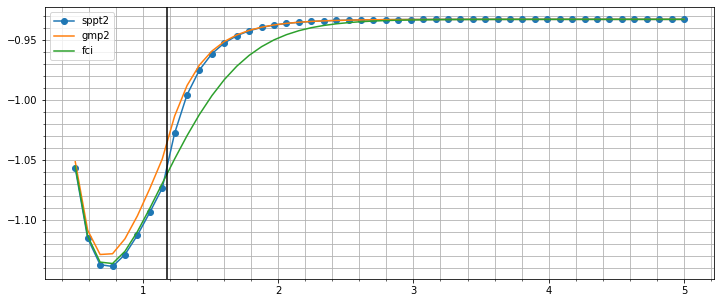

In [275]:
plt.plot(bond_lengths, e_sppt2_0_nonorm, '-o', label='sppt2')
plt.plot(bond_lengths, e_gmp2_0, label='gmp2')
plt.plot(bond_lengths, e_fci_0, label='fci')
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(b=True, which='both')
plt.axvline(x=1.18, ymin=0, ymax=1, color='black')
plt.legend()
plt.show()

Let's try plotting 1st-order energy without the overall normalization.

In [272]:
%autoreload
import sppt2_v2

s = m = k = 0
bond_lengths, e_sppt2_1_nonorm, e_gmp2_1, e_fci_1 = sppt2_v2.bond_curve(2, s, m, k, order=1, divide_norm=False)


Bond Length: 0.5
Building molecule...
Using basis set sto-3g

*** Check energy ***

alphas = [3.142 6.283]
betas = [1.571]
ws = [2.]
Ng = 1

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
E_mp2 = -2.1098404914619864
alpha_t = 3.141592653589793
beta_g = 1.5707963267948966
ws_g = 2.0
d^s_mk = 1.0

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
E_mp2 = -2.1098404914619864
alpha_t = 6.283185307179586
beta_g = 1.5707963267948966
ws_g = 2.0
d^s_mk = 1.0

SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679

s = 0
m

/Users/shufay/envs/pyscf2/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


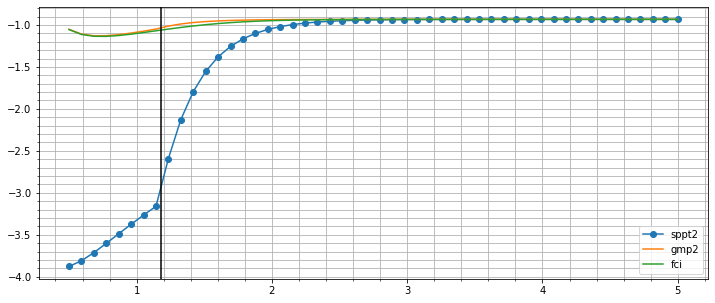

In [273]:
plt.plot(bond_lengths, e_sppt2_1_nonorm, '-o', label='sppt2')
plt.plot(bond_lengths, e_gmp2_1, label='gmp2')
plt.plot(bond_lengths, e_fci_1, label='fci')
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(b=True, which='both')
plt.axvline(x=1.18, ymin=0, ymax=1, color='black')
plt.legend()
plt.show()

## Corrections as a function of bond length

In [259]:
%autoreload
def corrections(n, s, m, k, order=3, divide_norm=True, start=0.5, stop=5., points=50, basis='sto-3g'):
    bond_lengths = np.linspace(start, stop, points)
    dms = None
    corrections = []

    for bond_length in bond_lengths:
        print('\nBond Length: {}'.format(bond_length))
        mol = sppt2_v2.build_chain(n, bond_length, basis)
        nao = mol.nao

        if dms is None:
            uhf = scf.UHF(mol).run(dms, verbose=0)
            dms = uhf.make_rdm1()
            
        dms[0][0, 0]+=1.0    
        uhf = scf.UHF(mol).run(dms, verbose=0)
        dms = uhf.make_rdm1()
        fock = uhf.get_fock()
        test = sppt2_v2.SPPT2(mol, fock=fock)
        
        # Compute corrections.
        correction, nterm = test.energy_xterms(s, m, k, order=order, separate=True) / test.norm(s, m, k)
        
        print('\n=====================================')
        print(f'{order} order correction = {correction}\n')

        corrections.append(correction)
    
    print(f'nterms = {nterm}')
        
    return bond_lengths, corrections

In [261]:
bond_lengths, corrections_0 = corrections(2, s, m, k, order=0)


Bond Length: 0.5
Building molecule...
Using basis set sto-3g
SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679

0 order correction = 0j


Bond Length: 0.5918367346938775
Building molecule...
Using basis set sto-3g
SCF not converged.
SCF energy = -0.796915866410806 after 0 cycles  <S^2> = 3.9125647e-11  2S+1 = 1
E(GMP2) = -1.1083578706246  E_corr = -0.0100524240969281
SCF not converged.
SCF energy = -0.796915866410806 after 0 cycles  <S^2> = 3.9125647e-11  2S+1 = 1
E(GMP2) = -1.1083578706246  E_corr = -0.0100524240969281

0 order correction = 0j


Bond Length: 0.6836734693877551
Building molecule...
Using basis set sto-3g
SCF not converged.
SCF energy = -0.785179998218698 after 0 cycles  <S^2> = 4.2985815e-10  2S+1 = 1
E(GMP

/Users/shufay/envs/pyscf2/lib/python3.7/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


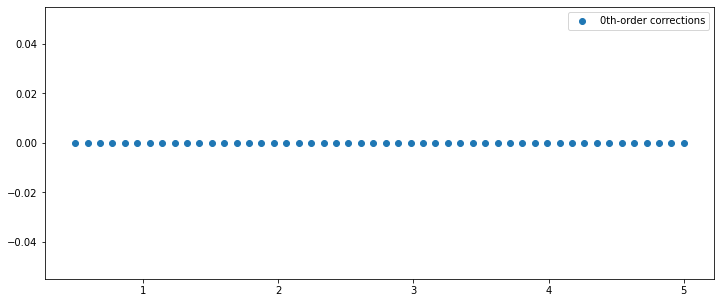

In [219]:
plt.scatter(bond_lengths, corrections_0, label='0th-order corrections')
plt.legend()
plt.show()

In [262]:
corrections_0

[0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j]

In [263]:
bond_lengths, corrections_1 = corrections(2, s, m, k, order=1)


Bond Length: 0.5
Building molecule...
Using basis set sto-3g
SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679

1 order correction = (-1.4069722692658868+2.5845661135005274e-16j)


Bond Length: 0.5918367346938775
Building molecule...
Using basis set sto-3g
SCF not converged.
SCF energy = -0.796915866410806 after 0 cycles  <S^2> = 3.9125647e-11  2S+1 = 1
E(GMP2) = -1.1083578706246  E_corr = -0.0100524240969281
SCF not converged.
SCF energy = -0.796915866410806 after 0 cycles  <S^2> = 3.9125647e-11  2S+1 = 1
E(GMP2) = -1.1083578706246  E_corr = -0.0100524240969281

1 order correction = (-1.3431309544410746+2.4672915161388184e-16j)


Bond Length: 0.6836734693877551
Building molecule...
Using basis set sto-3g
SCF not converged.

/Users/shufay/envs/pyscf2/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


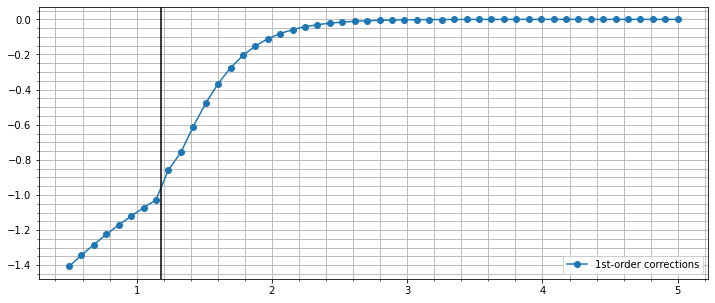

In [264]:
plt.plot(bond_lengths, corrections_1, '-o', label='1st-order corrections')
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(b=True, which='both')
plt.axvline(x=1.18, ymin=0, ymax=1, color='black')
plt.legend()
plt.show()

In [254]:
corrections_1

[(-1.4069722692658868+2.5845661135005274e-16j),
 (-1.3431309544410746+2.4672915161388184e-16j),
 (-1.2823677793621882+2.3556714234932463e-16j),
 (-1.2249742781066146+2.2502411983705166e-16j),
 (-1.1710304871841384+2.1511480470565663e-16j),
 (-1.1203816950109042+2.0581077875504954e-16j),
 (-1.0727340800709375+1.9705793927014162e-16j),
 (-1.027775660080856+1.8880048194928256e-16j),
 (-0.8581308367919571+1.5763619507501133e-16j),
 (-0.7574935908471091+1.3914931503142793e-16j),
 (-0.6106554063669584+1.1217557832066752e-16j),
 (-0.4782795892955242+8.785853521577041e-17j),
 (-0.36640770538137984+6.730800352930751e-17j),
 (-0.27608541287297056+5.071606757690913e-17j),
 (-0.20546816193687092+3.774388903546752e-17j),
 (-0.15150594756043112+2.783119106329382e-17j),
 (-0.11093632269744667+2.0378671884193412e-17j),
 (-0.08078878122394596+1.4840658379516754e-17j),
 (-0.05857333271334768+1.0759746652146914e-17j),
 (-0.04173712647489536+7.666985723648838e-18j),
 (-0.030140797886276993+5.5367747732796

In [277]:
e2 = np.array(e_sppt2_0) + np.array(corrections_1) / 2

/Users/shufay/envs/pyscf2/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


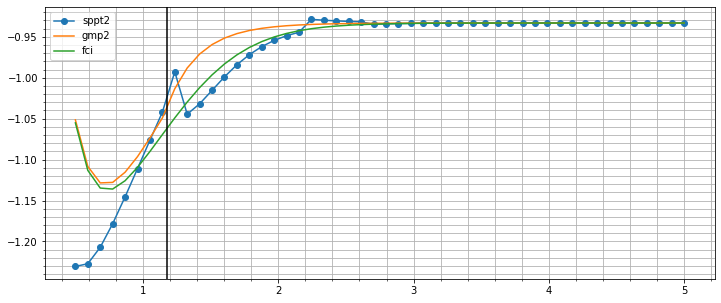

In [279]:
plt.plot(bond_lengths, e2, '-o', label='sppt2')
plt.plot(bond_lengths, e_gmp2_1, label='gmp2')
plt.plot(bond_lengths, e_fci_1, label='fci')
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(b=True, which='both')
plt.axvline(x=1.18, ymin=0, ymax=1, color='black')
plt.legend()
plt.show()

In [222]:
bond_lengths, corrections_2 = corrections(2, s, m, k, order=2)


Bond Length: 0.5
Building molecule...
Using basis set sto-3g
SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679

s = 0
m = 0
k = 0
2 order correction = 0j


Bond Length: 0.5918367346938775
Building molecule...
Using basis set sto-3g
SCF not converged.
SCF energy = -0.796915866410806 after 0 cycles  <S^2> = 3.9125647e-11  2S+1 = 1
E(GMP2) = -1.1083578706246  E_corr = -0.0100524240969281
SCF not converged.
SCF energy = -0.796915866410806 after 0 cycles  <S^2> = 3.9125647e-11  2S+1 = 1
E(GMP2) = -1.1083578706246  E_corr = -0.0100524240969281

s = 0
m = 0
k = 0
2 order correction = 0j


Bond Length: 0.6836734693877551
Building molecule...
Using basis set sto-3g
SCF not converged.
SCF energy = -0.785179998218698 after 0 cycles  <

/Users/shufay/envs/pyscf2/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


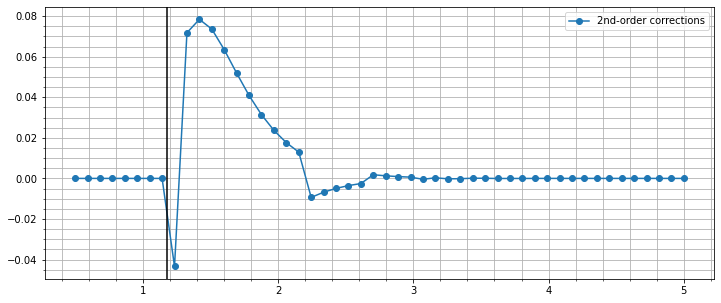

In [247]:
plt.plot(bond_lengths, corrections_2, '-o', label='2nd-order corrections')
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(b=True, which='both')
plt.axvline(x=1.18, ymin=0, ymax=1, color='black')
plt.legend()
plt.show()

In [255]:
corrections_2

[0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 (-0.04339010346651424+0j),
 (0.0717884566338558+0j),
 (0.07839157037446243+0j),
 (0.07360790458896922+0j),
 (0.06348608543058844+0j),
 (0.05188276131322657+0j),
 (0.04088428124764719+0j),
 (0.031405427469961805+0j),
 (0.023684335062261874+0j),
 (0.017620265862111933+0j),
 (0.012974207124731045+0j),
 (-0.009349208325108938+0j),
 (-0.006806911684468894+0j),
 (-0.004922729860465476+0j),
 (-0.003538608494337034+0j),
 (-0.002529126762154571+0j),
 (0.0018024536382151004+0j),
 (0.0012729696446497503+0j),
 (0.0008941942422577349+0j),
 (0.0006246942537627913+0j),
 (-0.00043372232574843717+0j),
 (0.00029988539046086547+0j),
 (-0.0002060150549946068+0j),
 (-0.00014083538431553829+0j),
 (9.578900601666011e-05+0j),
 (6.480594372155929e-05+0j),
 (-4.362393839820359e-05+0j),
 (-2.922476013763102e-05+0j),
 (-1.9483242089362462e-05+0j),
 (-1.2925397189045147e-05+0j),
 (8.532293444859333e-06+0j),
 (5.603319430210235e-06+0j),
 (-3.66012501393234e-06+0j),
 (2.37743

In [224]:
bond_lengths, corrections_3 = corrections(2, s, m, k, order=3)


Bond Length: 0.5
Building molecule...
Using basis set sto-3g
SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679
SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 7.1078698e-12  2S+1 = 1
E(GMP2) = -1.05148606962199  E_corr = -0.00848979508474679

s = 0
m = 0
k = 0
3 order correction = 0j


Bond Length: 0.5918367346938775
Building molecule...
Using basis set sto-3g
SCF not converged.
SCF energy = -0.796915866410806 after 0 cycles  <S^2> = 3.9125647e-11  2S+1 = 1
E(GMP2) = -1.1083578706246  E_corr = -0.0100524240969281
SCF not converged.
SCF energy = -0.796915866410806 after 0 cycles  <S^2> = 3.9125647e-11  2S+1 = 1
E(GMP2) = -1.1083578706246  E_corr = -0.0100524240969281

s = 0
m = 0
k = 0
3 order correction = 0j


Bond Length: 0.6836734693877551
Building molecule...
Using basis set sto-3g
SCF not converged.
SCF energy = -0.785179998218698 after 0 cycles  <

/Users/shufay/envs/pyscf2/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


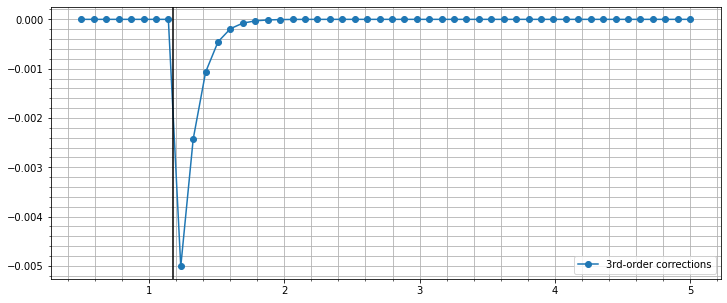

In [248]:
plt.plot(bond_lengths, corrections_3, '-o', label='3rd-order corrections')
ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.grid(b=True, which='both')
plt.axvline(x=1.18, ymin=0, ymax=1, color='black')
plt.legend()
plt.show()

In [257]:
corrections_3

[0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 0j,
 (-0.005010059277221124+9.203334837130137e-19j),
 (-0.0024276052670534893+4.459438547288113e-19j),
 (-0.0010691589378560799+1.9640131067805311e-19j),
 (-0.0004551370991102824+8.360732878253577e-20j),
 (-0.0001885613404698009+3.4638156324723836e-20j),
 (-7.647261500457343e-05+1.404779147698796e-20j),
 (-3.0489717657676056e-05+5.600870262931162e-21j),
 (-1.1989718952670155e-05+2.202475638971946e-21j),
 (-4.660950485451212e-06+8.562027154116269e-22j),
 (-1.7940301129451893e-06+3.295579838047964e-22j),
 (-6.843473555288628e-07+1.2571257064472207e-22j),
 (-2.5532766425762205e-07+4.690293124021032e-23j),
 (-9.603737145010638e-08+1.7641778850158016e-23j),
 (-3.574700849016917e-08+6.566618696049232e-24j),
 (-1.315714261037481e-08+2.4169278913045347e-24j),
 (-4.783389786008491e-09+8.78694432486474e-25j),
 (-1.7205696852312213e-09+3.160635200094351e-25j),
 (-6.078559310267856e-10+1.1166126142609942e-25j),
 (-2.1150915577805778e-10+3.8853541477149126e-26j),

## What did we learn?
1. We know that most of the error is coming from the <(0)|H|(0)> term. 
2. The normalization curve as a function of bond length seems weird. I'm not sure if that is what we expect.

## Next Steps

1. I think the easiest way to proceed for now is to ask Xing if we can directly evaluate the matrix elements in pySCF.
    - I should checkout how it's done in the CI code first.  
    
2. Figure out how the normalization depends on the UHF/RHF solutions.

3. What happens if we take $w_g = 1$?

Let's see if our formulas can recover the 0th-order energies.

In [501]:
%autoreload
def e(test, s, m, k, order=3):
    ghfs, t2s = test.get_quad_ghfs_t2s()
    n_alpha = len(ghfs)
    n_beta = len(ghfs[0])

    # < psi(0)_g | H | psi(0)_g' >
    matrix_elems_00 = np.zeros((n_alpha, n_beta, n_alpha, n_beta), dtype=np.complex)

    # < psi(0)_g | H | psi(1)_g' >
    matrix_elems_01 = np.zeros((n_alpha, n_beta, n_alpha, n_beta), dtype=np.complex)

    # < psi(1)_g | H | psi(1)_g' >
    matrix_elems_11 = np.zeros((n_alpha, n_beta, n_alpha, n_beta), dtype=np.complex)

    for row1, ghf_row1 in enumerate(ghfs):
        for col1, ghf1 in enumerate(ghf_row1):
            mo_coeff1 = ghf1.mo_coeff
            mo_occ1 = ghf1.mo_occ
            mo_coeff2, mo_occ2 = mo_coeff1, mo_occ1
            row2, col2 = row1, col1

            # Array of doubly excited mo_occs.
            mo_occ1_ds = test.get_all_doubles(mo_occ1)
            mo_occ2_ds = test.get_all_doubles(mo_occ2)

            # < psi(0)_g | H | psi(0)_g' >
            matrix_elems_00[row1, col1, row2, col2] = test.get_matrix_element(
                mo_coeff1, mo_coeff2, mo_occ1, mo_occ2)

            if order == 1:
                continue

            # Skip <(0)|H|(1)> matrix elements where <(0)|(1)> = 0.
            ovlp = test.det_ovlp(mo_coeff1, mo_coeff2, mo_occ1, mo_occ2)[0]
            if ovlp < 1e-7:
                continue

            # < psi(0)_g | H | psi(1)_g' >
            matrix_elem_01 = 0

            # < psi(1)_g | H | psi(1)_g' >
            matrix_elem_11 = 0

            for mo_occ2_d in mo_occ2_ds:
                i, j, a, b = [int(s) for s in mo_occ2_d.split(',')]
                matrix_elem_sd = test.get_matrix_element(
                    mo_coeff1, mo_coeff2, mo_occ1, mo_occ2_ds[mo_occ2_d])

                matrix_elem_01 += t2s[row2][col2][i, j, a % test.nelec, b % test.nelec] * matrix_elem_sd 

                if order == 2:
                    continue

                for mo_occ1_d in mo_occ1_ds:
                    h, l, c, d = [int(s) for s in mo_occ1_d.split(',')]
                    matrix_elem_dd = test.get_matrix_element(
                        mo_coeff1, mo_coeff2, mo_occ1_ds[mo_occ1_d], mo_occ2_ds[mo_occ2_d], doubles=mo_occ1_d)

                    matrix_elem_11 += np.conj(t2s[row1][col1][h, l, c % test.nelec, d % test.nelec]) * \
                        t2s[row2][col2][i, j, a % test.nelec, b % test.nelec] * matrix_elem_dd

            matrix_elems_01[row1, col1, row2, col2] = matrix_elem_01
            matrix_elems_11[row1, col1, row2, col2] = matrix_elem_11


    coeffs = np.sqrt(test.quad_coeffs(s, m, k))
    x_energy = 0

    for alpha_g in range(n_alpha):
        for beta_g in range(n_beta):
            alpha_gp, beta_gp = alpha_g, beta_g

            """
            DONT THINK THIS IS CORRECT.
            """
            if order == 0:
                continue

            elif order == 1:
                x_energy += np.conj(coeffs[alpha_g, beta_g]) * coeffs[alpha_gp, beta_gp] * \
                    (matrix_elems_00[alpha_g, beta_g, alpha_gp, beta_gp])

            elif order == 2:
                x_energy += np.conj(coeffs[alpha_g, beta_g]) * coeffs[alpha_gp, beta_gp] * \
                    (matrix_elems_00[alpha_g, beta_g, alpha_gp, beta_gp] + \
                     matrix_elems_01[alpha_g, beta_g, alpha_gp, beta_gp] + \
                     np.conj(matrix_elems_01[alpha_gp, beta_gp, alpha_g, beta_g]))

            elif order == 3:
                x_energy += np.conj(coeffs[alpha_g, beta_g]) * coeffs[alpha_gp, beta_gp] * \
                    (matrix_elems_00[alpha_g, beta_g, alpha_gp, beta_gp] + \
                     matrix_elems_01[alpha_g, beta_g, alpha_gp, beta_gp] + \
                     np.conj(matrix_elems_01[alpha_gp, beta_gp, alpha_g, beta_g]) + \
                     matrix_elems_11[alpha_g, beta_g, alpha_gp, beta_gp])


    return x_energy

In [502]:
%autoreload
import sppt2_v2

def build_chain(n, bond_length, basis='6-31g'):
    """
    Builds a hydrogen chain of n H atoms.

    Args
        n (int): number of H atoms.
        bond_length (float): bond length between adjacent H atoms.
        basis (str): type of basis to use.

    Returns
        Hchain
    """
    print('Building molecule...')
    print('Using basis set {}'.format(basis))
    Hchain = gto.Mole()
    Hchain.atom = [['H', (bond_length * i, 0., 0.)] for i in range(n)]
    Hchain.basis = basis
    Hchain.spin = 0
    Hchain.build()
    return Hchain


def bond_curve(n, s, m, k, order=3, start=0.5, stop=5., points=50, basis='sto-3g'):
    bond_lengths = np.linspace(start, stop, points)
    dms = None
    gdms = None
    e_sppt2s = []
    e_gmp2s = []
    e_fcis = []
    

    for bond_length in bond_lengths:
        print('\nBond Length: {}'.format(bond_length))
        mol = build_chain(n, bond_length, basis)
        nao = mol.nao

        if dms is not None: # dms is a list containing [dmalpha,dmbeta]
            dms[0][0, 0]+=1.0
        
        uhf = scf.UHF(mol).run(dms, verbose=0)
        dms = uhf.make_rdm1()
        fock = uhf.get_fock()

        # Test SPPT2 rotate fock.
        test = sppt2_v2.SPPT2(mol, fock=fock)
        
        # Test energy.
        e_sppt2 = e(test, s, m, k, order=order)
        print('\n=====================================')
        print(f's = {s}')
        print(f'm = {m}')
        print(f'k = {k}')
        print(f'SPPT2 E = {e_sppt2}\n')

        # FCI energy.
        rhf = scf.RHF(mol).run(verbose=0)
        fci_out = fci.FCI(rhf).run(verbose=0)
        print(f'FCI E = {fci_out.e_tot}')
        print('=====================================\n')

        # GMP2 energy.
        if gdms is not None: # dms is a list containing [dmalpha,dmbeta]
            gdms[0, 0]+=1.0
            
        ghf = scf.GHF(mol).run(gdms, verbose=0)
        gdms = ghf.make_rdm1()
        gmp2 = mp.GMP2(ghf).run()

        # Store energies.
        e_sppt2s.append(e_sppt2)
        e_gmp2s.append(gmp2.e_tot)
        e_fcis.append(fci_out.e_tot)
        
    return bond_lengths, e_sppt2s, e_gmp2s, e_fcis

In [503]:
%autoreload

s = m = k = 0
bond_lengths, e_sppt2_orig, e_gmp2_orig, e_fci_orig = bond_curve(2, s, m, k, order=3)


Bond Length: 0.5
Building molecule...
Using basis set sto-3g
SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 0  2S+1 = 1
E(GMP2) = -1.05148606962497  E_corr = -0.00848979508487271
SCF not converged.
SCF energy = -0.780918750956874 after 0 cycles  <S^2> = 0  2S+1 = 1
E(GMP2) = -1.05148606962497  E_corr = -0.00848979508487271

s = 0
m = 0
k = 0
SPPT2 E = (-3.7321768398916393+0j)

FCI E = -1.0551597944706248

E(GMP2) = -1.05148606962497  E_corr = -0.0084897950848727

Bond Length: 0.5918367346938775
Building molecule...
Using basis set sto-3g
SCF not converged.
SCF energy = -0.796915866410806 after 0 cycles  <S^2> = 3.9130754e-11  2S+1 = 1
E(GMP2) = -1.1083578706246  E_corr = -0.010052424096928
SCF not converged.
SCF energy = -0.796915866410806 after 0 cycles  <S^2> = 3.9130754e-11  2S+1 = 1
E(GMP2) = -1.1083578706246  E_corr = -0.010052424096928

s = 0
m = 0
k = 0
SPPT2 E = (522416637095385.1+4.948385653813203e-16j)

FCI E = -1.1131939862063605

E(GMP2) = -1.10

/Users/shufay/envs/pyscf2/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


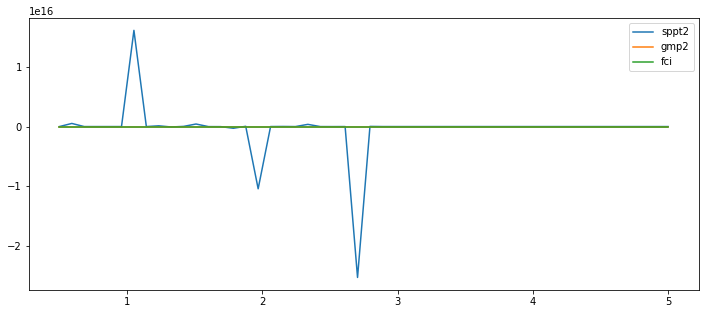

In [504]:
plt.plot(bond_lengths, e_sppt2_orig, label='sppt2')
plt.plot(bond_lengths, e_gmp2_orig, label='gmp2')
plt.plot(bond_lengths, e_fci_orig, label='fci')
plt.legend()
plt.show()

In [113]:
np.set_printoptions(precision=7)

all_s1 = 0
all_s2 = 0
all_s3 = 0
large = [] # stores matrix elements > 10
small = [] # stores matrix elements < 10

for i1, ghf_rows1 in enumerate(ghfs):
    for j1, ghf1 in enumerate(ghf_rows1):
        for i2, ghf_rows2 in enumerate(ghfs):
            for j2, ghf2 in enumerate(ghf_rows2):
                if (i1, j1) == (i2, j2):
                    continue
                    
                alpha1 = alphas[i1]
                beta1 = betas[j1]
                alpha2 = alphas[i2]
                beta2 = betas[j2]
                ghf_mocc1 = ghf1.mo_occ
                ghf_mocc2 = ghf2.mo_occ
                ghf_mocoeff1 = ghf1.mo_coeff
                ghf_mocoeff2 = ghf2.mo_coeff
                
                ovlp1 = test.det_ovlp(ghf_mocoeff1, ghf_mocoeff2, ghf_mocc1, ghf_mocc2)[0]
                me1 = test.get_matrix_element(ghf_mocoeff1, ghf_mocoeff2, ghf_mocc1, ghf_mocc2)
                
                print(f'alpha1 = {alpha1}')
                print(f'beta1 = {beta1}')
                print(f'alpha2 = {alpha2}')
                print(f'beta2 = {beta2}\n')
                
                """
                print('\n***** ghf info *****\n')
                
                print(f'ghf_mocoeff1 diag: {np.diagonal(ghf_mocoeff1)}\n')
                print(f'ghf_mocoeff2 diag: {np.diagonal(ghf_mocoeff2)}')
                
                for i in range(5):
                    print(f'ghf_mocoeff1 diag: \n{ghf_mocoeff1[:, i]}\n')
                    print(f'ghf_mocoeff2 diag: \n{ghf_mocoeff2[:, i]}\n')
                """
                
                print('\n<(0)|(0)> \t\t\t\t\t <(0)|H|(0)>\n')
                print(f'{ovlp1:.4e} \t\t\t\t {me1:.4e}')
                
                doubles1 = test.get_all_doubles(ghf_mocc1)
                doubles2 = test.get_all_doubles(ghf_mocc2)
                ovlp2s = []
                ovlp3s = []
                me2s = []
                me3s = []
                
                for d2 in doubles2:
                    ovlp2 = test.det_ovlp(ghf_mocoeff1, ghf_mocoeff2, ghf_mocc1, doubles2[d2])[0]
                    me2 = test.get_matrix_element(ghf_mocoeff1, ghf_mocoeff2, ghf_mocc1, doubles2[d2])
                    ovlp2s.append(ovlp2)
                    me2s.append(me2)
                    
                    for d1 in doubles1:
                        ovlp3 = test.det_ovlp(ghf_mocoeff1, ghf_mocoeff2, doubles1[d1], doubles2[d2])[0]
                        me3 = test.get_matrix_element(
                            ghf_mocoeff1, ghf_mocoeff2, doubles1[d1], doubles2[d2], doubles=d1)
                        ovlp3s.append(ovlp3)
                        me3s.append(me3)
                    
                print('\n<(0)|(1)> \t\t\t\t\t <(0)|H|(1)>\n')
                print(len(ovlp2s))
                s2 = 0
                
                for i, ovlp2 in enumerate(ovlp2s):
                    if ovlp2 < 1e-7:
                        s2 += 1
                        print(f'{ovlp2:.4e} \t\t\t\t\t {me2s[i]:.4e}')
                        
                        if (abs(np.real(me2s[i])) > 10) or (abs(np.imag(me2s[i])) > 10):
                            large.append(('01', ovlp2, me2s[i]))
                            
                        else:
                            small.append(('01', ovlp2, me2s[i]))
                
                print(f'smaller than 0 = {s2}')
                
                print('\n<(1)|(1)> \t\t\t\t\t <(1)|H|(1)>\n')
                print(len(ovlp3s))
                s3 = 0
                
                for j, ovlp3 in enumerate(ovlp3s):
                    if ovlp3 < 1e-7:
                        s3 += 1
                        print(f'{ovlp3:.4e} \t\t\t\t {me3s[j]:.4e}')
                        
                        if (abs(np.real(me3s[j])) > 10) or (abs(np.imag(me3s[j])) > 10):
                            large.append(('11', ovlp3, me3s[j]))
                            
                        else:
                            small.append(('11', ovlp3, me3s[j]))
                        
                print(f'smaller than 0 = {s3}')    
                print('\n\n')
                
                all_s2 += s2
                all_s3 += s3

alpha1 = 1.5707963267948966
beta1 = 0.9553166181245093
alpha2 = 1.5707963267948966
beta2 = 2.186276035465284


<(0)|(0)> 					 <(0)|H|(0)>

6.8480e-01 				 -1.1102e-16-1.8769e-15j

<(0)|(1)> 					 <(0)|H|(1)>

36
smaller than 0 = 0

<(1)|(1)> 					 <(1)|H|(1)>

1296
smaller than 0 = 0



alpha1 = 1.5707963267948966
beta1 = 0.9553166181245093
alpha2 = 3.141592653589793
beta2 = 0.9553166181245093


<(0)|(0)> 					 <(0)|H|(0)>

6.8480e-01 				 1.4261e-01+9.4747e-01j

<(0)|(1)> 					 <(0)|H|(1)>

36
smaller than 0 = 0

<(1)|(1)> 					 <(1)|H|(1)>

1296
smaller than 0 = 0



alpha1 = 1.5707963267948966
beta1 = 0.9553166181245093
alpha2 = 3.141592653589793
beta2 = 2.186276035465284


<(0)|(0)> 					 <(0)|H|(0)>

3.6988e-01 				 0.0000e+00+1.7525e+00j

<(0)|(1)> 					 <(0)|H|(1)>

36
smaller than 0 = 0

<(1)|(1)> 					 <(1)|H|(1)>

1296
smaller than 0 = 0



alpha1 = 1.5707963267948966
beta1 = 0.9553166181245093
alpha2 = 4.71238898038469
beta2 = 0.9553166181245093


<(0)|(0)> 					 <(0)|H|(0)

In [114]:
print(len(large))

6131


In [115]:
print(len(small))

749


OK, that wasn't what I was expecting. I thought that if the overlaps were 0, then we'll get matrix elements that blow up. But we're seeing that there are still plenty of matrix elements that are <10. Hmm...

In [51]:
for i in small:
    print(i)

('11', 2.7070121884505445e-16, (-0.49650064796288823-1.3697255891307076j))
('11', 1.8889833356832026e-16, (-0.967059484581819-5.993505157371363j))
('11', 1.9141466776480353e-16, (0.7944318409846198+2.2247819979605334j))
('11', 1.33571292791265e-16, (0.33443487906900027-2.6227817314069224j))
('11', 1.394028698729698e-16, (-0.5039061727784417+0.6150440952832654j))
('11', 9.530393122874393e-17, (0.975034045360579+1.1825163934045166j))
('11', 9.857271456724974e-17, (-2.8346641373252908+8.831726183505355j))
('11', 6.73900561314854e-17, (-1.355703889275763+9.399208542273378j))
('11', 3.9287733286035917e-47, (-4.1882176327793985-2.496709055209516j))
('11', 1.9141461299507764e-16, (-0.8581478210446978-5.229727258433381j))
('11', 2.6714255897043487e-16, (-0.7869115862287559-5.134838149820358j))
('11', 1.3535057103342708e-16, (0.4327796768668049-1.635216347211533j))
('11', 1.888983152323159e-16, (0.5145824707428281-1.7641151017367873j))
('11', 9.857276094125339e-17, (-2.178646221891978+1.0364256

## TODO:
- Check if I rotated my Focks correctly.
- Check if I computed the density matrices correctly.